# Gykorlat 08
## Lineáris regresszió regularizálása és Bias - Variancia
### Vízfolyás
A feladat első felében implementálásra kerül egy lineáris regresszi, hogy előrejelezhessük a kifolyt víz mennyiségét egy tartályból, annak alapján, hogy abban mennyi víz van. A feladat második felében megfigyeljük a tanulóalgoritmusok debuggolását és a bias v.s. variancia hatását.

### 1: Importálás, adatok betöltése

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as op

data = loadmat("Lab8data.mat")                          # adatok betöltése
X = data["X"]                                           # adatok szerkesztése változókba
Y = data["y"]
X_test = data["Xtest"]
Y_test = data["ytest"]
X_val = data["Xval"]
Y_val = data["yval"]

del data
m,n = X.shape
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (12, 1)
Shape of Y: (12, 1)


### 2: Adatok vizualiálása

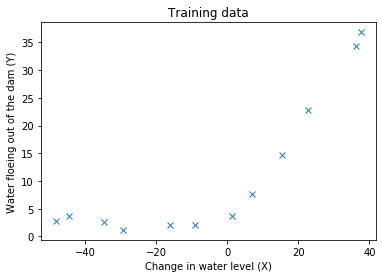

In [2]:
plt.plot(X,Y,'x')                                       # adatok megjelenítése
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.show()

### 3: Regularizált lineáris regresszió

In [3]:
def linearRegCostFunction(w,*args):
    X,y,Lambda = args
    m,n = X.shape
    y=y.reshape(m,1)
    C=0;

    w_0 = w.copy().reshape(n,1)
    w_0[0] = 0

    penalty = (Lambda/(2*m))*np.sum(w_0**2)
    C = (1/(2*m)) * (np.sum(((X @ w)-y)**2)) + penalty

    return C

def linRegGrad(w,*args):
    X,y,Lambda = args

    m,n = X.shape
    y=y.reshape(m,1)

    w_0 = w.copy()
    w_0[0] = 0

    w = w.reshape(n,1)
    grad = (1 / m) * np.sum((((X @ w) - y) * X), 0) + ((Lambda / m) * w_0.T)

    return grad


w = np.array([[1],[1]])
C = linearRegCostFunction(w,np.column_stack((np.ones((m,1)),X)),Y,1)
grad = linRegGrad(w,np.column_stack((np.ones((m,1)),X)),Y,1)
print('''Cost at weight (1;1):
Expected (approx.): 303.993
Computed:''',C, '''
Gradient expected (approx.): [-15.303015 598.2507]
Gradient computed:''', grad)

Cost at weight (1;1):
Expected (approx.): 303.993
Computed: 303.9931922202643 
Gradient expected (approx.): [-15.303015 598.2507]
Gradient computed: [[-15.30301567 598.25074417]]


### 4: Lineáris regresszió tanítása

Weights with the optimization: [[13.0879035 ]
 [ 0.36777923]]


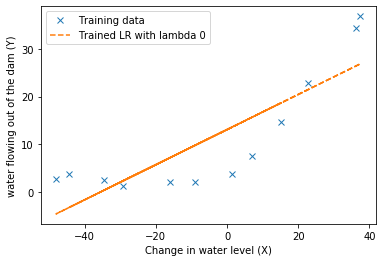

In [9]:
def trainLinearReg(X,y,Lambda):
    args = (X,y.flatten(),Lambda)
    init_w = np.ones((X.shape[1],1))
    
    res1 = op.fmin_ncg(linearRegCostFunction,init_w.flatten(),fprime=linRegGrad, args=args, disp=0)
    
    return np.array(res1).reshape(n+1,1)


Lambda = 0
w = trainLinearReg(np.column_stack((np.ones((m,1)),X)),Y,Lambda)
print('Weights with the optimization:',w)

plt.plot(X,Y,'x',label='Training data')
plt.plot(X,np.column_stack((np.ones((m,1)),X)) @ w,'--', label='Trained LR with lambda 0')
plt.xlabel('Change in water level (X)')
plt.ylabel('water flowing out of the dam (Y)')
plt.legend()
plt.show()

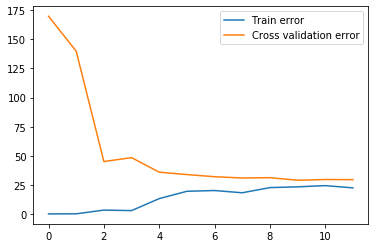

In [10]:
def linearRegCostFunction1(w,*args):
    X,y,Lambda = args
    m,n = X.shape
    y=y.reshape(m,1)
    C=0;

    w_0 = w.copy().reshape(n,1)
    w_0[0] = 0

    penalty = (Lambda/(2*m))*np.sum(w_0**2)
    C = (1/(2*m)) * (np.sum(((X @ w)-y)**2)) + penalty

    return C

def learningCurve(X,Y,X_val,Y_val,Lambda):
    m = X.shape[0]

    error_train = np.zeros((m,1))
    error_val = np.zeros((m,1))

    for i in range (1,m+1):
        w = trainLinearReg(X[0:i,:],Y[0:i],Lambda)
        error_train[i-1] = linearRegCostFunction1(w,X[0:i,:],Y[0:i],Lambda)
        error_val[i-1] = linearRegCostFunction(w,X_val,Y_val,Lambda)
            
    return error_train, error_val


Lambda = 0
error_train, error_val = learningCurve(np.column_stack((np.ones((m,1)),X)),Y,\
                                       np.column_stack((np.ones((X_val.shape[0],1)),X_val)),Y_val,0)

plt.plot(error_train, label = "Train error")
plt.plot(error_val, label = "Cross validation error")
plt.legend()
plt.show()